In [1]:
settings = {
    "xsrf_cookies": False,
}

In this notebook we explore using random forest to determine activity values of molecules (using regression) and predicting an active/inactive molecule (using classification).  First we load the fingerprints from RDkit.

In [1]:
import pandas as pd
import itertools
from sklearn.ensemble import RandomForestClassifier, RandomForestRegressor
from sklearn.model_selection import train_test_split
from sklearn.inspection import permutation_importance
from sklearn.metrics import classification_report, confusion_matrix
import matplotlib.pyplot as plt
import numpy as np

data = pd.read_pickle('../processed_data/combined_dataset.pkl')
N=len(data.loc[data['target'] == 'TMPRSS2']) #number of compounds tested against TMPRSS2 itself
fp_dark=pd.read_pickle('../processed_data/DarkChemicalMatter_processed.pkl.gz')
fp_dark=np.stack(fp_dark['morgan_fingerprint'])

We have two sets of activity values since not all compound assays were performed against TMPRSS2 (the protease of interest in this study).  Thus, some compounds' activity values have to be scaled via a correlation of the protease they were originally purposed for, against TMPRSS2.  We save the binary values of whether a compound was deemed active/inactive as "activity", and the numeric activity value as "ac_merged".  Also we note if the values are taken from the "scaled" dataset.  Ac values are converted to negative log10.  Finally we convert everything to numpy array to input into random forest.

In [2]:
#convert to array
#using merged data from pickle
datalabels=list(data['target'])
fps_merged=np.stack(data['morgan_fingerprint'])
ac_merged_scaled=np.asarray(data['acvalue_scaled_to_tmprss2'])
cids=list(data['cid'])
act_list=list(data['activity_target'])
activity_scaled=[]
activity=[]
for i in range(len(act_list)):
    if act_list[i] == 'Active':
        activity.append(1)
    else:
        activity.append(0)
    if ac_merged_scaled[i]>0:
        if act_list[i] == 'Active':
            activity_scaled.append(1)
        else:
            activity_scaled.append(0)
#alternatively
ac_merged=np.asarray(data['acvalue_target'])
#keep only the positive vals in ac_merged
fps_merged_scaled=fps_merged[ac_merged_scaled>0]
cids_scaled=[cid for i, cid in enumerate(cids) if ac_merged_scaled[i]>0]
ac_merged_scaled=ac_merged[ac_merged_scaled>0]

activity=np.array(activity)
ac_merged=np.array(ac_merged)
ac_merged=-np.log10(ac_merged)
activity_scaled=np.array(activity_scaled)
ac_merged_scaled=np.array(ac_merged_scaled)
ac_merged_scaled=-np.log10(ac_merged_scaled)

/Users/schu3/.conda/envs/covid/lib/python3.7/site-packages/ipykernel_launcher.py:23: RuntimeWarning: invalid value encountered in greater
/Users/schu3/.conda/envs/covid/lib/python3.7/site-packages/ipykernel_launcher.py:25: RuntimeWarning: invalid value encountered in greater


Now we split the training and the test data.  To test how well the random forest works, we split the compounds with known TMPRSS2 activity (that is, their recorded ac value is from an assay against TMPRSS2) between the training and test sets.  Here I've used a 2/3 training 1/3 test split, which can be changed by changing variable "n_test".  The indices assigned by the split is randomly shuffled each time the code is run.

In [4]:
#split train and test 
#split the tmprss2 active compounds into training and test
import random
s=np.arange(N)
random.seed(33)#set seed for reproducibility
random.shuffle(s)
n_test=round(N/3) #percentage to withold for testing
cut=n_test
test=s[0:cut]
train=s[cut::]

Here we generate training and test sets for the classifier, which incorporates the "dark chemical matter" which is known to be inactive.  We split the dark chemical matter evenly between the test and training sets.  You can skip the following code block if not running the classifier.  The purpose of the classifier is to do a preliminary "filtering" of active/inactive molecules for the regressor.

In [5]:
s=np.arange(len(fp_dark))
random.shuffle(s)
cut=round(len(fp_dark)/2)
test_dark=s[0:cut]
train_dark=s[cut::]
X_test=np.concatenate((fps_merged_scaled[test], fp_dark[test_dark]))
X_train=np.concatenate((fps_merged_scaled[train], fps_merged_scaled[92::], fp_dark[train_dark]))
y_train=np.concatenate((activity_scaled[train], activity_scaled[92::], np.zeros([len(train_dark)])))
y2_train=np.concatenate((ac_merged_scaled[train], ac_merged_scaled[92::], np.zeros([len(train_dark)])))
y_test=np.concatenate((activity_scaled[test], np.zeros([len(test_dark)])))
y2_test=np.concatenate((ac_merged_scaled[test],np.zeros([len(test_dark)])))

X_test_u=np.concatenate((fps_merged[test], fp_dark[test_dark]))
X_train_u=np.concatenate((fps_merged[train], fps_merged[92::], fp_dark[train_dark]))
y_train_u=np.concatenate((activity[train], activity[92::], np.zeros([len(train_dark)])))
y2_train_u=np.concatenate((ac_merged[train], ac_merged[92::], np.zeros([len(train_dark)])))
y_test_u=np.concatenate((activity[test], np.zeros([len(test_dark)])))
y2_test_u=np.concatenate((ac_merged[test],np.zeros([len(test_dark)])))
#generate big training set
X_train_all=np.concatenate((fps_merged_scaled, fp_dark))
y2_train_all=np.concatenate((ac_merged_scaled, np.zeros([len(fp_dark)])))
y_train_all=np.concatenate((activity_scaled, np.zeros([len(fp_dark)])))

Here we run the classifier for the test case (where our test set has some compounds with known TMPRSS2 activity).

In [6]:
###YOU CAN SKIP THIS STEP IF NOT RUNNING THE CLASSIFIER###
rf=RandomForestClassifier(verbose=2, n_estimators=100, random_state=111)
rf.fit(np.asarray(X_train), np.asarray(y_train))

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


building tree 1 of 100


[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.3s remaining:    0.0s


building tree 2 of 100
building tree 3 of 100
building tree 4 of 100
building tree 5 of 100
building tree 6 of 100
building tree 7 of 100
building tree 8 of 100
building tree 9 of 100
building tree 10 of 100
building tree 11 of 100
building tree 12 of 100
building tree 13 of 100
building tree 14 of 100
building tree 15 of 100
building tree 16 of 100
building tree 17 of 100
building tree 18 of 100
building tree 19 of 100
building tree 20 of 100
building tree 21 of 100
building tree 22 of 100
building tree 23 of 100
building tree 24 of 100
building tree 25 of 100
building tree 26 of 100
building tree 27 of 100
building tree 28 of 100
building tree 29 of 100
building tree 30 of 100
building tree 31 of 100
building tree 32 of 100
building tree 33 of 100
building tree 34 of 100
building tree 35 of 100
building tree 36 of 100
building tree 37 of 100
building tree 38 of 100
building tree 39 of 100
building tree 40 of 100
building tree 41 of 100
building tree 42 of 100
building tree 43 of 100


[Parallel(n_jobs=1)]: Done 100 out of 100 | elapsed:   36.5s finished


RandomForestClassifier(random_state=111, verbose=2)

In [7]:
y_pred=rf.predict(X_test)
print(rf.score(X_test, y_test))

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done 100 out of 100 | elapsed:    0.9s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s


0.9999856530035437


[Parallel(n_jobs=1)]: Done 100 out of 100 | elapsed:    0.9s finished


and we see how well it does in terms of precision and recall.

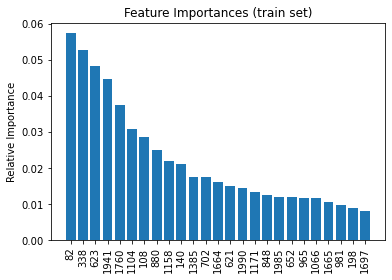

              precision    recall  f1-score   support

         0.0       1.00      1.00      1.00     69670
         1.0       1.00      0.97      0.98        31

    accuracy                           1.00     69701
   macro avg       1.00      0.98      0.99     69701
weighted avg       1.00      1.00      1.00     69701



In [8]:
#get the index of the features (of RDkit fingerprint) that were important
importances = rf.feature_importances_
featurenums = np.array([str(x).zfill(2) for x in range(len(importances))])
indices = np.argsort(importances)[::-1][0:25]#get the 25 most important features
plt.title('Feature Importances (train set)')
plt.bar(range(len(indices)), importances[indices], align='center')
plt.ylabel('Relative Importance')
plt.xticks(range(len(indices)), featurenums[indices], rotation=90)
plt.show()
#output metrics
print(classification_report(y_test, y_pred))

REGRESSION
Here we again take the same random splits of training and test set (set by the variable "n_test") as a proportion of compounds in the ground truth TMPSSR2 assay data, but we don't add the dark data, which can distort the results of regression. We train both the "scaled" version with scaled data and the version with unscaled data.

In [101]:
import random
from sklearn.metrics import mean_squared_error
n_bootstrap = 50
mse_unscaled=np.zeros(n_bootstrap)
mse_scaled=np.zeros(n_bootstrap)
random.seed(33)
for i in range(n_bootstrap):
        s=np.arange(N)
        #set seed for reproducibility
        random.shuffle(s)
        n_test=round(N/3) #percentage to withold for testing
        cut=n_test
        test=s[0:cut]
        train=s[cut::]
        X_test_reg=fps_merged[test]
        X_train_reg=np.concatenate((fps_merged[train], fps_merged[92::]))
        y2_train_reg=np.concatenate((ac_merged[train], ac_merged[92::]))
        y2_test_reg=ac_merged[test]
        nan_array=np.isnan(y2_train_reg)
        X_train_reg=X_train_reg[~nan_array]
        y2_train_reg=y2_train_reg[~nan_array]
        #and generate for scaled arrays
        X_train_reg_scaled=np.concatenate((fps_merged_scaled[train], fps_merged_scaled[92::]))
        y2_train_reg_scaled=np.concatenate((ac_merged_scaled[train], ac_merged_scaled[92::]))
        rg_pos_only=RandomForestRegressor(verbose=0, n_estimators=100, random_state=111)
        rg_pos_only_scaled=RandomForestRegressor(verbose=0, n_estimators=100, random_state=111)
        rg_pos_only.fit(np.asarray(X_train_reg), np.asarray(y2_train_reg))
        rg_pos_only_scaled.fit(np.asarray(X_train_reg_scaled), np.asarray(y2_train_reg_scaled))
        y_pred_regr_pos=rg_pos_only.predict(X_test_reg)
        mse_unscaled[i]=mean_squared_error(y2_test_reg, y_pred_regr_pos)
        y_pred_regr_scaled_pos=rg_pos_only_scaled.predict(X_test_reg)
        mse_scaled[i]=mean_squared_error(y2_test_reg, y_pred_regr_scaled_pos)

Examine mean squared error (MSE) for both scaled and unscaled dataset, with 50 bootstrap random resamplings of the training set.  The scaled version appears to do slightly better (lower mean MSE) so we will use that.

0.6522259685038808
0.6288049077317978


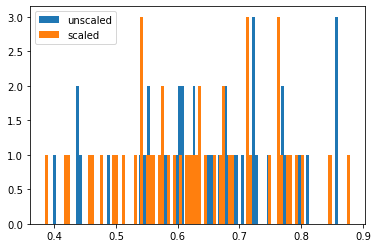

In [108]:
plt.hist(mse_unscaled, bins=100, label='unscaled')
plt.hist(mse_scaled, bins=100, label='scaled')
plt.legend()
print(np.mean(mse_unscaled))
print(np.mean(mse_scaled))

Here we select the 25 most important features from the morgan fingerprints.

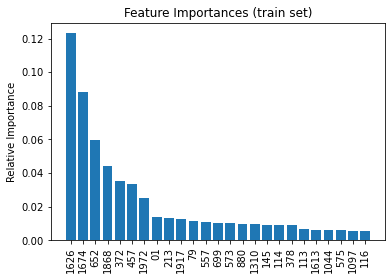

In [11]:
importances = rg_pos_only_scaled.feature_importances_
featurenums = np.array([str(x).zfill(2) for x in range(len(importances))])
indices = np.argsort(importances)[::-1][0:25]#get the 25 most important features
plt.title('Feature Importances (train set)')
plt.bar(range(len(indices)), importances[indices], align='center')
plt.ylabel('Relative Importance')
plt.xticks(range(len(indices)), featurenums[indices], rotation=90)
plt.show()

When we're satisfied with tuning the random forest regressor, we can build the regressor with all of the data combined to run on an unknown screening set.  First we load the screening dataset

In [75]:
screening_fp=pd.read_pickle('../processed_data/screening_data_processed.pkl')
screening_fp.head()
molnames_all=list(screening_fp['name'])
molnames_all=np.asarray(molnames_all)
screening=np.stack(screening_fp['morgan_fingerprint'])
sources=list(screening_fp['source'])
bitinfo=screening_fp['bitinfo']

,source,name,morgan_fingerprint,bitinfo
0,drugbank,Bivalirudin,"[0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...","{1: ((2, 0), (4, 0), (8, 0), (17, 0), (26, 0),..."
1,drugbank,Leuprolide,"[0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...","{1: ((12, 0), (23, 0), (25, 0), (31, 0), (33, ..."
2,drugbank,Goserelin,"[0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...","{1: ((1, 0), (4, 0), (8, 0), (18, 0), (30, 0),..."
3,drugbank,Gramicidin D,"[0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...","{1: ((1, 0), (4, 0), (12, 0), (16, 0), (22, 0)..."
4,drugbank,Desmopressin,"[0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...","{1: ((59, 0),), 20: ((60, 2),), 53: ((32, 2),)..."


Then build the regressor based on the scaled dataset

In [6]:
rg_all=RandomForestRegressor(verbose=2, n_estimators=100, random_state=111)
rg_all.fit(np.asarray(fps_merged_scaled), np.asarray(ac_merged_scaled))

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s


building tree 1 of 100
building tree 2 of 100
building tree 3 of 100
building tree 4 of 100
building tree 5 of 100
building tree 6 of 100
building tree 7 of 100
building tree 8 of 100
building tree 9 of 100
building tree 10 of 100
building tree 11 of 100
building tree 12 of 100
building tree 13 of 100
building tree 14 of 100
building tree 15 of 100
building tree 16 of 100
building tree 17 of 100
building tree 18 of 100
building tree 19 of 100
building tree 20 of 100
building tree 21 of 100
building tree 22 of 100
building tree 23 of 100
building tree 24 of 100
building tree 25 of 100
building tree 26 of 100
building tree 27 of 100
building tree 28 of 100
building tree 29 of 100
building tree 30 of 100
building tree 31 of 100
building tree 32 of 100
building tree 33 of 100
building tree 34 of 100
building tree 35 of 100
building tree 36 of 100
building tree 37 of 100
building tree 38 of 100
building tree 39 of 100
building tree 40 of 100
building tree 41 of 100
building tree 42 of 100
b

[Parallel(n_jobs=1)]: Done 100 out of 100 | elapsed:    2.1s finished


RandomForestRegressor(bootstrap=True, ccp_alpha=0.0, criterion='mse',
                      max_depth=None, max_features='auto', max_leaf_nodes=None,
                      max_samples=None, min_impurity_decrease=0.0,
                      min_impurity_split=None, min_samples_leaf=1,
                      min_samples_split=2, min_weight_fraction_leaf=0.0,
                      n_estimators=100, n_jobs=None, oob_score=False,
                      random_state=111, verbose=2, warm_start=False)

In [15]:
predicted_activity=rg_all.predict(screening)

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done 100 out of 100 | elapsed:    0.3s finished


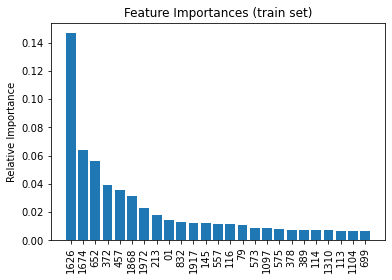

In [8]:
importances = rg_all.feature_importances_
featurenums = np.array([str(x).zfill(2) for x in range(len(importances))])
indices = np.argsort(importances)[::-1][0:25]#get the 25 most important features
plt.title('Feature Importances (train set)')
plt.bar(range(len(indices)), importances[indices], align='center')
plt.ylabel('Relative Importance')
plt.xticks(range(len(indices)), featurenums[indices], rotation=90)
plt.show()

Predict the activities from screening library and print the top 20 hits.  We also plot the predicted activity values color coded by screening library.

In [76]:
screening_fp['predicted_activity(log10)'] = predicted_activity
violinplot(x='source', y='predicted_activity(log10)', data=screening_fp)

In [77]:
screening_fp.sort_values(by='predicted_activity(log10)', ascending=False).head(20)

,source,name,smiles,rdkit_mol,morgan_fingerprint,bitinfo,predicted_activity(log10)
10797,reframe,Nafamostat,C1=CC(=CC=C1C(=O)OC2=CC3=C(C=C2)C=C(C=C3)C(=N)...,<rdkit.Chem.rdchem.Mol object at 0x177f87970>,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, ...","{11: ((23, 2),), 82: ((19, 2),), 140: ((21, 1)...",2.918984
10810,reframe,Patamostat,C1CC(=O)N(C1=O)CCSC2=CC=C(C=C2)OC(=O)C3=CC=C(C...,<rdkit.Chem.rdchem.Mol object at 0x177f8b030>,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 1, 0, ...","{11: ((26, 2),), 13: ((9, 2),), 80: ((7, 0), (...",2.853956
10749,reframe,Camostat,CN(C)C(=O)COC(=O)CC1=CC=C(C=C1)OC(=O)C2=CC=C(C...,<rdkit.Chem.rdchem.Mol object at 0x177f841b0>,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, ...","{11: ((26, 2),), 80: ((5, 0), (9, 0)), 140: ((...",2.736830
2513,drugbank,RWJ-56423,[H]N([H])C(=NCCC[C@H](N([H])C(=O)[C@@H]1C[C@@H...,<rdkit.Chem.rdchem.Mol object at 0x177b30b30>,"[0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...","{1: ((6, 0),), 80: ((3, 0), (4, 0), (5, 0)), 1...",2.494054
2928,drugbank,RWJ-51084,[H]N([H])C(=NCCC[C@H](N([H])C(=O)C1CCCC1)C(=O)...,<rdkit.Chem.rdchem.Mol object at 0x177b5cdf0>,"[0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...","{1: ((6, 0),), 80: ((3, 0), (4, 0), (5, 0)), 1...",2.484062
6887,drugbank,"1-[(4S)-4-amino-5-(1,3-benzothiazol-2-yl)-5-ox...",N[C@@H](CCCNC(N)=N)C(=O)C1=NC2=CC=CC=C2S1,<rdkit.Chem.rdchem.Mol object at 0x177d3b8f0>,"[0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...","{1: ((1, 0),), 80: ((2, 0), (3, 0), (4, 0)), 1...",1.956239
10789,reframe,RWJ-58643,CC(=O)N1C[C@H](O)C[C@H]1C(=O)NC(CCCNC(N)=N)C(=...,<rdkit.Chem.rdchem.Mol object at 0x177f87570>,"[0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...","{1: ((12, 0),), 80: ((13, 0), (14, 0), (15, 0)...",1.886184
10747,reframe,Sepimostat mesilate,[H]/N=C(/C1=CC=C2C=C(C=CC2=C1)OC(=O)C3=CC=C(C=...,<rdkit.Chem.rdchem.Mol object at 0x177f840b0>,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...","{89: ((26, 2),), 140: ((28, 1),), 145: ((14, 1...",1.757331
12704,broad,camostat-mesilate,CN(C)C(=O)COC(=O)Cc1ccc(OC(=O)c2ccc(NC(N)=N)cc...,<rdkit.Chem.rdchem.Mol object at 0x178168230>,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...","{80: ((5, 0), (9, 0)), 140: ((23, 1),), 145: (...",1.741743
9652,drugbank,Camostat,CN(C)C(=O)COC(=O)CC1=CC=C(OC(=O)C2=CC=C(NC(N)=...,<rdkit.Chem.rdchem.Mol object at 0x177e71470>,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...","{80: ((5, 0), (9, 0)), 140: ((23, 1),), 145: (...",1.741743


Information in the bits appears to be set to 1 when the structure is present in one of the compound's atoms, 0 if not.  Many of the features deemed "important" by the random forest are actually lack of structures (0 in a bit location), so here we try to determine what positive structures were important by retrieving these from the bit info of our top hits.

In [62]:
screening_fp=screening_fp.sort_values(by='predicted_activity(log10)', ascending=False)
bitinfo=screening_fp.iloc[0:20, :]['bitinfo']
keys1=[bitinfo[key] for key in bitinfo.keys()]
keys2=[]
for ik in keys1:
    iks=ik.keys()
    for ikey in iks:
        keys2.append(ikey)
keys1=[ik.keys() for ik in keys1]
keys1=np.asarray(keys1)
keys1=keys1.ravel()

keys2=[str(ikey) for ikey in keys2]
features2=[]
imps2=[]
for j, feature in enumerate(featurenums):
    if feature in keys2:
        features2.append(feature)
        imps2.append(importances[j])

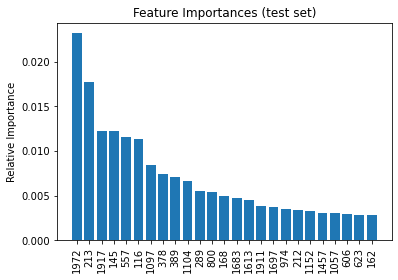

In [100]:
imps2=np.asarray(imps2)
features2=np.asarray(features2)
indices2 = np.argsort(imps2)[::-1][0:25]#get the 25 most important features of the test set
indices2=np.asarray(indices2)
plt.title('Feature Importances (test set)')
plt.bar(range(len(indices2)), imps2[indices2], align='center')
plt.ylabel('Relative Importance')
plt.xticks(range(len(indices2)), features2[indices2], rotation=90)
plt.show()

Now we draw the snippets of the relevant "top hits".

In [74]:
from rdkit.Chem import Draw

In [95]:
nafsvg = Draw.DrawMorganBit(screening_fp['rdkit_mol'][10797], 1917, screening_fp['bitinfo'][10797], useSVG=True)
nafsvg2  = Draw.DrawMorganBit(screening_fp['rdkit_mol'][10797], 145, screening_fp['bitinfo'][10797], useSVG=True)
patsvg = Draw.DrawMorganBit(screening_fp['rdkit_mol'][17040], 1917, screening_fp['bitinfo'][17040], useSVG=True)
patsvg2  = Draw.DrawMorganBit(screening_fp['rdkit_mol'][17040], 145, screening_fp['bitinfo'][17040], useSVG=True)
camsvg = Draw.DrawMorganBit(screening_fp['rdkit_mol'][10749], 1917, screening_fp['bitinfo'][10749], useSVG=True)
camsvg2  = Draw.DrawMorganBit(screening_fp['rdkit_mol'][10749], 145, screening_fp['bitinfo'][10749], useSVG=True)
cam2svg = Draw.DrawMorganBit(screening_fp['rdkit_mol'][12704], 1917, screening_fp['bitinfo'][12704], useSVG=True)
cam2svg2  = Draw.DrawMorganBit(screening_fp['rdkit_mol'][12704], 145, screening_fp['bitinfo'][12704], useSVG=True)

In order: nafamostat (ReFrame tautomer), patamostat, camostat, camostat (Broad tautomer).  These are the same two features in separate molecules.

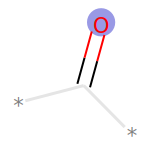

In [90]:
nafsvg #feature 1917

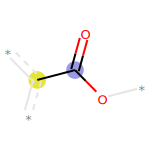

In [89]:
nafsvg2 #feature 145

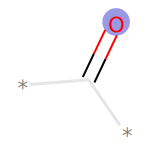

In [93]:
patsvg

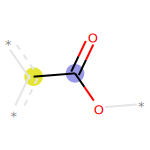

In [92]:
patsvg2

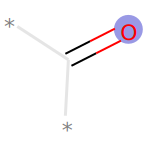

In [96]:
camsvg

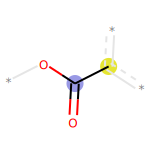

In [97]:
camsvg2

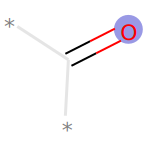

In [98]:
cam2svg

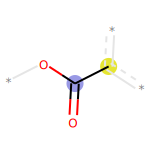

In [99]:
cam2svg2